In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
hmeq=pd.read_csv(r"C:\Users\chemm\Desktop\cours\MOSEF\Python\Exercice\Scoring\Projet_scoring\data\hmeq.csv")
hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


Imputation des données

In [3]:
MissingData = hmeq.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values')
MissingData['Percentage Missing'] = (MissingData['Missing Values'] / len(hmeq)) * 100
MissingData = MissingData.sort_values(by='Percentage Missing', ascending=False)
MissingData

,Variables,Missing Values,Percentage Missing
12,DEBTINC,1267,21.258389
7,DEROG,708,11.879195
8,DELINQ,580,9.731544
2,MORTDUE,518,8.691275
6,YOJ,515,8.640940
10,NINQ,510,8.557047
9,CLAGE,308,5.167785
5,JOB,279,4.681208
4,REASON,252,4.228188
11,CLNO,222,3.724832


In [4]:
hmeq_filled = hmeq.copy()
variables_numeriques = ['DEBTINC', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE', 'DEROG', 'DELINQ']
for var in variables_numeriques:
    hmeq_filled[var] = hmeq_filled[var].fillna(hmeq_filled[var].median())

variables_categorielles = ['JOB', 'REASON']
for var in variables_categorielles:
    hmeq_filled[var] = hmeq_filled[var].fillna(hmeq_filled[var].mode()[0])
    
print(hmeq_filled.isnull().sum())

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64


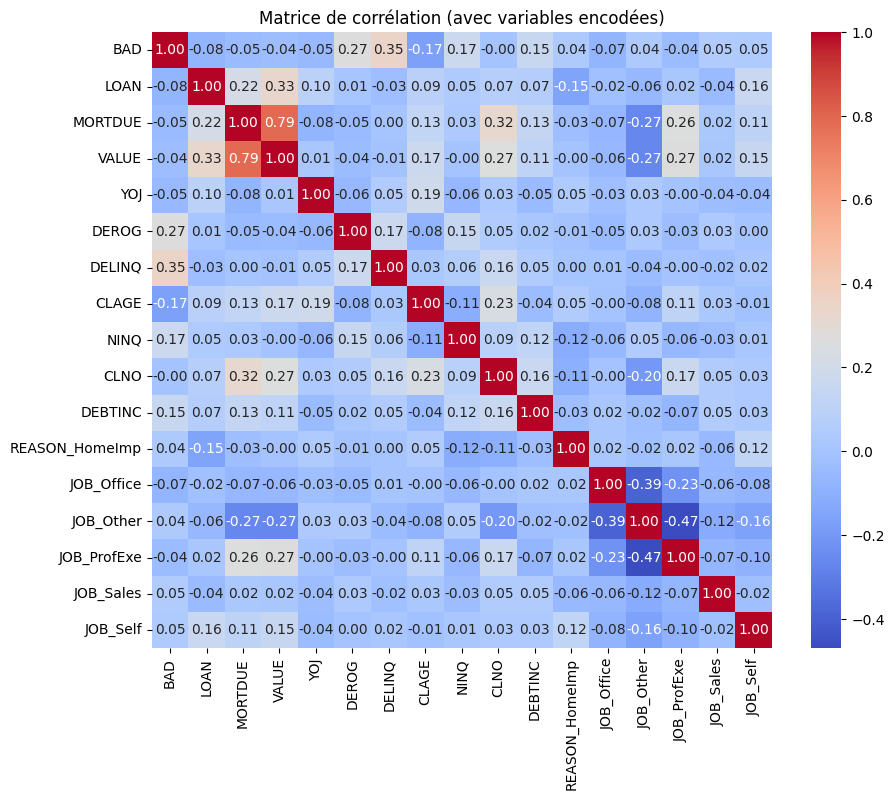

In [5]:
hmeq_encoded = pd.get_dummies(hmeq_filled, drop_first=True) 
corr_matrix_encoded = hmeq_encoded.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_encoded, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation (avec variables encodées)')
plt.show()

In [6]:
hmeq_encoded.corr()['BAD'].sort_values(ascending=False)

BAD               1.000000
DELINQ            0.346503
DEROG             0.269921
NINQ              0.170031
DEBTINC           0.154544
JOB_Sales         0.050934
JOB_Self          0.046245
JOB_Other         0.037949
REASON_HomeImp    0.037517
CLNO             -0.004543
VALUE            -0.036492
JOB_ProfExe      -0.043561
MORTDUE          -0.046186
YOJ              -0.053956
JOB_Office       -0.073613
LOAN             -0.075099
CLAGE            -0.165614
Name: BAD, dtype: float64

D'apres l'exploration de données, on sait que : 
DELINQ, DEROG, NINQ, et DEBTINC sont les variables les plus pertinentes pour prédire BAD et devraient être privilégiées dans la modélisation.

CLAGE montre une corrélation négative, suggérant qu'elle peut apporter des informations complémentaires 

MORTDUE et VALUE (0.79) : Forte corrélation entre ces deux variables. Cela indique qu'il pourrait y avoir une redondance entre elles. Il peut être pertinent de combiner ces deux variables en un ratio prêt/valeur (Loan-to-Value Ratio) ou d'en supprimer une pour éviter la multicolinéarité

CLNO et CLAGE (0.23) : Corrélation modérée, ce qui est logique car plus un emprunteur a de comptes ouverts, plus il est probable que ces comptes soient plus anciens

DELINQ et DEROG (0.60) : Forte corrélation, ce qui est également attendu puisque les emprunteurs avec des lignes de crédit délinquantes ont souvent aussi des dossiers dérogatoires

In [16]:
from sklearn.preprocessing import StandardScaler

# Sélectionner les colonnes numériques (sans les colonnes cibles et variables catégorielles encodées)
numeric_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

# Instancier le scaler
scaler = StandardScaler()

# Appliquer le scaler sur les variables numériques
hmeq_encoded[numeric_columns] = scaler.fit_transform(hmeq_encoded[numeric_columns])


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Calculer le VIF pour chaque variable
X = hmeq_encoded[numeric_columns]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


   Feature       VIF
0     LOAN  1.148122
1  MORTDUE  2.828596
2    VALUE  2.902140
3      YOJ  1.075041
4    DEROG  1.064305
5   DELINQ  1.064109
6    CLAGE  1.137936
7     NINQ  1.060637
8     CLNO  1.229266
9  DEBTINC  1.056259
